In [1]:
# install libraries
!pip install tensorflow_datasets -q

In [2]:
# import libraries
import os
import cv2
import tqdm
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import (preprocess_input,
                                                    decode_predictions)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, Input, Dense, Flatten,
                                     MaxPooling2D, Dropout, BatchNormalization)

2024-05-04 17:58:18.666560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 17:58:18.666680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 17:58:18.809912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Construct a tf.data.Dataset
train_ds = tfds.load('cassava', split='train', shuffle_files=True)
test_ds = tfds.load('cassava', split='test', shuffle_files=True)

# Build input pipeline
train_ds = train_ds.shuffle(10).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteQW139S/cassava-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteQW139S/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteQW139S/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [5]:
images = []
labels = []

for example in train_ds:
    
    image = example["image"]
    label = example["label"]
    image = cv2.resize(np.array(image), (128, 128)) #resize the image
    images.append(image), labels.append(np.array(label))

In [6]:
# Function to visualize digits in a grid
def visualize_grid(images, labels):
    
    rows, cols = 3, 3  # Adjust rows and cols for a different grid size
    figure, axes = plt.subplots(rows, cols, figsize=(16, 12))  # Create a figure and subplots

    for i in range(rows):
        for j in range(cols):
            image_idx = i * cols + j  # Calculate index for each image
            image = images[image_idx]  # Reshape for visualization
            label = labels[image_idx]
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"Label: {label}")
            axes[i, j].axis('off')  # Hide axes for cleaner visualization

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Select a subset of images and labels for visualization
num_images = 9  # Adjust num_images to show a different number of digits
image_indices = range(num_images)  # Select the first num_images from the dataset
images_to_visualize = images[:num_images]
labels_to_visualize = labels[:num_images]

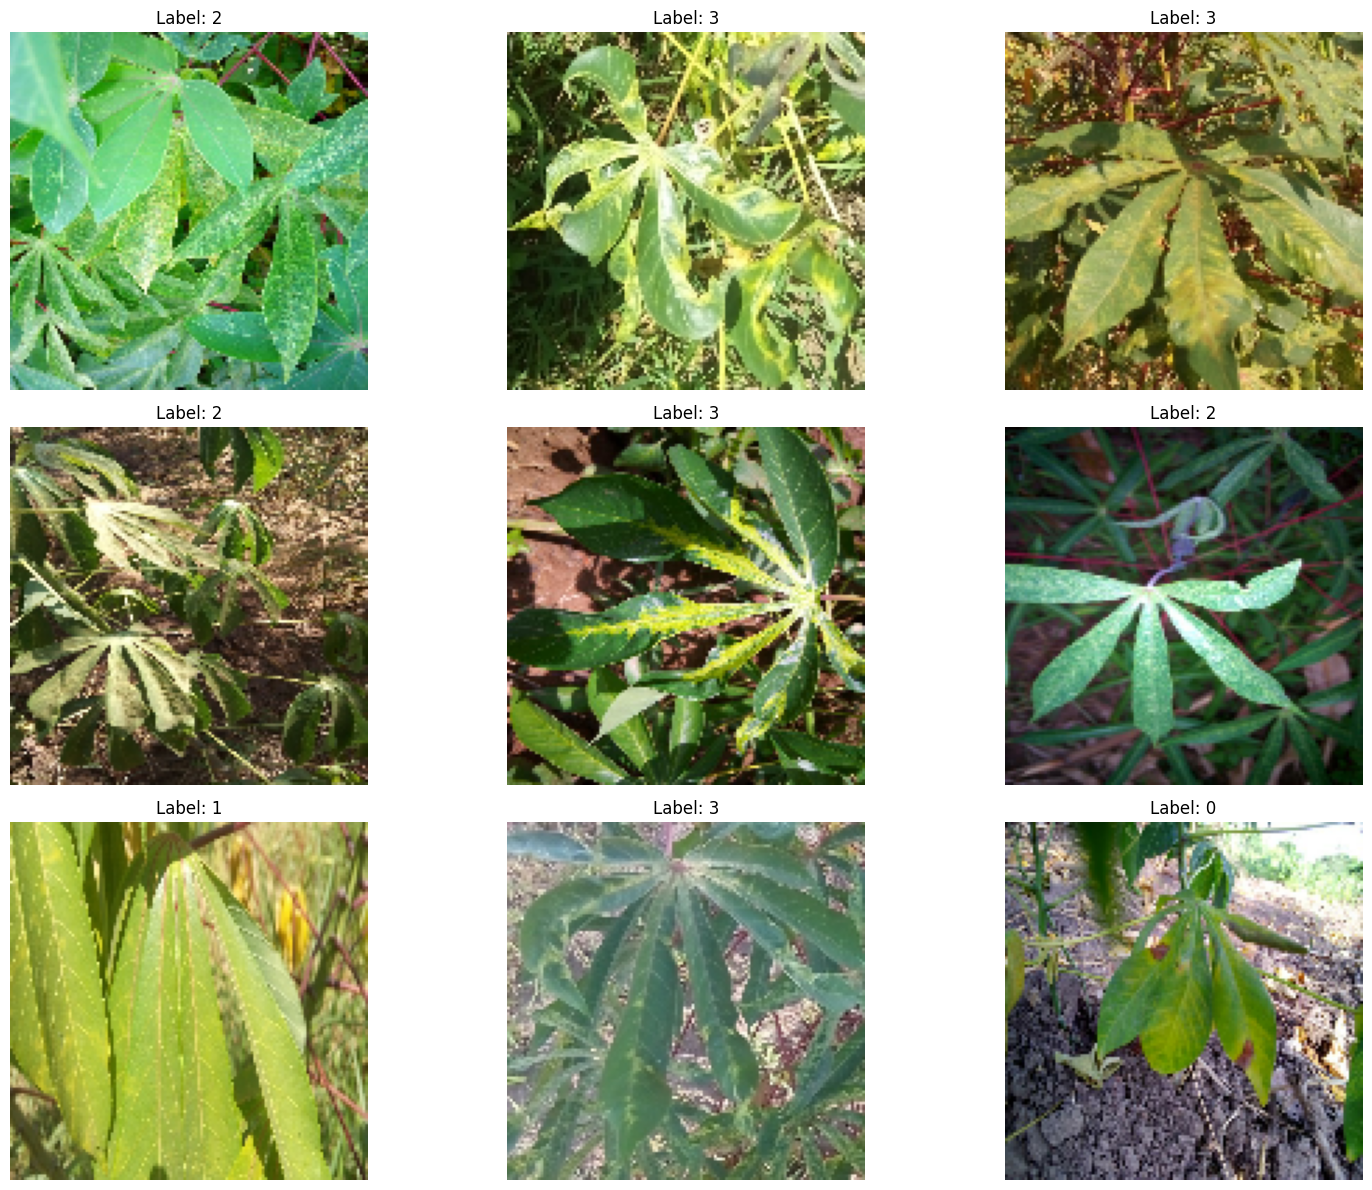

In [7]:
# Visualize digits in a 3x3 grid
visualize_grid(images_to_visualize[:10], labels_to_visualize[:10])

In [9]:
# unique labels
lr = [int(num) for num in labels]

count_dict = {}

# Loop through each element in the list
for item in lr:
    if item in count_dict:
        count_dict[item] += 1  # Increment the count if item is already in the dictionary
    else:
        count_dict[item] = 1 
print(count_dict)

{2: 773, 3: 2658, 1: 1443, 0: 466, 4: 316}


In [10]:
num_classes = 5
one_hot_labels = to_categorical(labels, num_classes) # encode label with one hot encodeing

train_images = np.reshape(np.array(images), (-1,128,128,3)) # reshape image
train_images = train_images/255. # normalize image
train_labels = np.reshape(np.array(one_hot_labels), (-1,5)) #reshape labels

In [12]:
# Define a Sequential model
model = Sequential([
  # First layer: 2D convolution layer with 264 filters, kernel size of 3x3, and 'relu' activation function. 
  # 'valid' padding means no padding is applied, and this is the first layer so it includes input shape.
  Conv2D(264, input_shape=(128, 128, 3), kernel_size=(3, 3), padding='valid', activation='relu'),
  # Second convolution layer, same configuration as above without input shape
  Conv2D(264, kernel_size=(3, 3), padding='valid', activation='relu'),
    
  # First MaxPooling layer with pool size 2x2 to reduce spatial dimensions
  MaxPooling2D(pool_size=(2, 2)),
  # Additional convolution layers with same configuration
  Conv2D(264, kernel_size=(3, 3), padding='valid', activation='relu'),
  Conv2D(264, kernel_size=(3, 3), padding='valid', activation='relu'),
  # Dropout layer to prevent overfitting by dropping out 40% of the neurons
  Dropout(0.4),
  
  # Convolution layers with fewer filters (128)
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Dropout(0.4),  # Again, applying dropout for regularization
    
  # Second MaxPooling layer to further reduce dimensionality
  MaxPooling2D(pool_size=(2, 2)),
  # More convolution layers with 128 filters
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Dropout(0.4),  # Dropout for regularization
  
  # Continuing with the same pattern of convolution and dropout layers
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
  Dropout(0.4),
    
  # Reduction of filter size to 64 for these layers
  Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
  Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
  Dropout(0.3),  # Slightly less dropout rate

  # Flatten layer to convert the 3D feature maps to 1D feature vectors
  Flatten(),  
  # Fully connected (Dense) layers with 'relu' activation for high-level reasoning
  Dense(units=264, activation='relu'),  
  Dense(units=128, activation='relu'),
  Dropout(0.3),  # Dropout in dense layer for regularization
  Dense(units=128, activation='relu'),
  # Output layer with 5 units and softmax activation for multi-class classification
  Dense(units=5, activation='softmax') 
])
# Set checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(
                            'v1_{epoch:02d}_{val_accuracy:.3f}.keras',
                              save_best_only = True,
                              monitor = 'val_accuracy',
                              mode = 'max')

# Compile the model (specifies optimizer, loss function, and metrics)
lr = 0.0001
optimize = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimize, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 264)  │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 124, 124, 264)  │       627,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 264)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 264)    │       627,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 58, 58, 264)    │       627,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 58, 58, 264)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │       304,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 54, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 17, 17, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 264)            │     3,801,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           64

 Total params: 6,895,813 (26.31 MB)

 Trainable params: 6,895,813 (26.31 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history=model.fit(train_images, train_labels, epochs=10,validation_split=0.3, batch_size = 16,  callbacks = [checkpoint])

Epoch 1/10


I0000 00:00:1714845733.994222     178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714845734.023317     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4560 - loss: 1.3979

W0000 00:00:1714845836.531574     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714845838.485383     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


248/248 ━━━━━━━━━━━━━━━━━━━━ 195s 473ms/step - accuracy: 0.4561 - loss: 1.3978 - val_accuracy: 0.4850 - val_loss: 1.3939
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 66s 265ms/step - accuracy: 0.4848 - loss: 1.3049 - val_accuracy: 0.5439 - val_loss: 1.2282
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.5907 - loss: 1.1807 - val_accuracy: 0.6223 - val_loss: 1.1851
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.6093 - loss: 1.1141 - val_accuracy: 0.5380 - val_loss: 1.2294
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.6013 - loss: 1.1167 - val_accuracy: 0.6258 - val_loss: 1.0461
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.6140 - loss: 1.0820 - val_accuracy: 0.6405 - val_loss: 1.0473
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 264ms/step - accuracy: 0.6174 - loss: 1.0574 - val_accuracy: 0.6423 - val_loss: 1.0271
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 65s 262ms/step - accuracy: 0.6407 - loss: 1.0128 - va

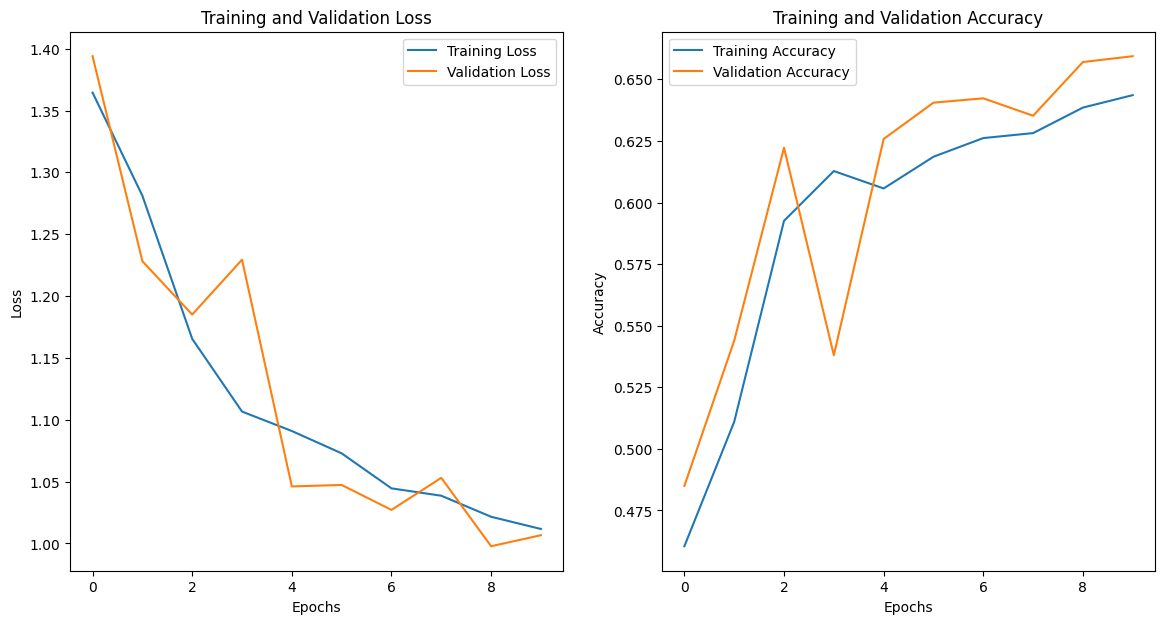

In [14]:
# Extracting all metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 7))

# Subplot 1: Plot training and validation loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Plot training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Model Evaluation

In [15]:
test_images, test_labels = [], []
for example in test_ds:
    
    image = example["image"]
    label = example["label"]
    image = cv2.resize(np.array(image), (128,128))
    test_images.append(image), test_labels.append(np.array(label))
    
test_labels = to_categorical(test_labels, num_classes)
test_labels = np.reshape(np.array(test_labels), (-1,5))
test_images = np.reshape(np.array(test_images), (-1,128, 128, 3))/255

In [18]:
saved_model = keras.saving.load_model("/kaggle/working/v1_09_0.657.keras")

In [21]:
test_loss, test_acc = saved_model.evaluate(test_images, test_labels)
print("Test Accuracy:", test_acc)

 1/59 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.5625 - loss: 1.1286

W0000 00:00:1714846854.947432     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6426 - loss: 1.0046
Test Accuracy: 0.6525198817253113


W0000 00:00:1714846863.562099     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
